# Bias and Variance
In this notebook we will create a simulation example to understand better bias and variance.

## Terminology
Suppose we have training set consisting of   
$X$ : Vector of **N** observations of independent variable.  
$Y$ : Vector of **N** observations of dependent variable.  
And assume $Y$ is related to $X$ by a function $f(X)$ and noise $\epsilon$.  
$Y = f(X) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$. 

Lets assume we take a subsets of $X$ and $Y$, $X_\mathcal{D}$ and $Y_\mathcal{D}$ and we fit a model to that subset and the fitted model is $\hat{f}(X_\mathcal{D})$.   
For a new data point $x$ and $y$ outside of $X$ and $Y$.

MSE = $\mathbb{E}[(y-\hat{f}(x))^2 ]$, where Expectation is over all the possible $D$ sets from the training set.   

$\begin{align}
\mathbb{E}[(y-\hat{f}(x))^2 ] &= \mathbb{E}[(f(x)-\hat{f}(x) + \epsilon)^2 ] \\
     &= \mathbb{E}[(f(x)-\hat{f}(x)+\epsilon+\mathbb{E}[\hat{f}(x)]-\mathbb{E}[\hat{f}(x)])^2] \\
     &= \mathbb{E}[(f(x)-\mathbb{E}[\hat{f}(x)]+\epsilon+\mathbb{E}[\hat{f}(x)]-\hat{f}(x))^2] \\
     &= \mathbb{E}[(f(x)-\mathbb{E}[\hat{f}(x)])^2] + \mathbb{E}[\epsilon^2] + \mathbb{E}[(\mathbb{E}[\hat{f}(x)]-\hat{f}(x))^2] \\ 
     &+ 2\mathbb{E}[\epsilon (f(x) - \mathbb{E}[\hat{f}(x))] + 2\mathbb{E}[\epsilon (\mathbb{E}[\hat{f}(x)]-\hat{f}(x))] + 2\mathbb{E}[(f(x)-\mathbb{E}[\hat{f}(x)])(\mathbb{E}[\hat{f}(x)]-\hat{f}(x)]]
\end{align}$

Using $\mathbb{E}(\epsilon) = 0$, $\mathbb{E}[f(x)] = f(x)$ and $\mathbb{E}[\mathbb{E}[\hat{f}(x)]]=\mathbb{E}[\hat{f}(x)]$, we get   

$\begin{align}
\mathbb{E}[(y-\hat{f}(x))^2] &= \underbrace{\mathbb{E}[(f(x)-\mathbb{E}[\hat{f}(x)])^2]}_{Bias} + \underbrace{\sigma^2 }_{\text{Irreducible Error}}+ \underbrace{\mathbb{E}[(\mathbb{E}[\hat{f}(x)]-\hat{f}(x))^2]}_{Variance}
\end{align}$

Lets make an example and see these terms numerically.

$f(X) = X^4-5X^2+4$   
$Y = f(X) + \epsilon \sim \mathcal{N}(0, \sigma^2 = 0.1^2)$

In [2]:
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

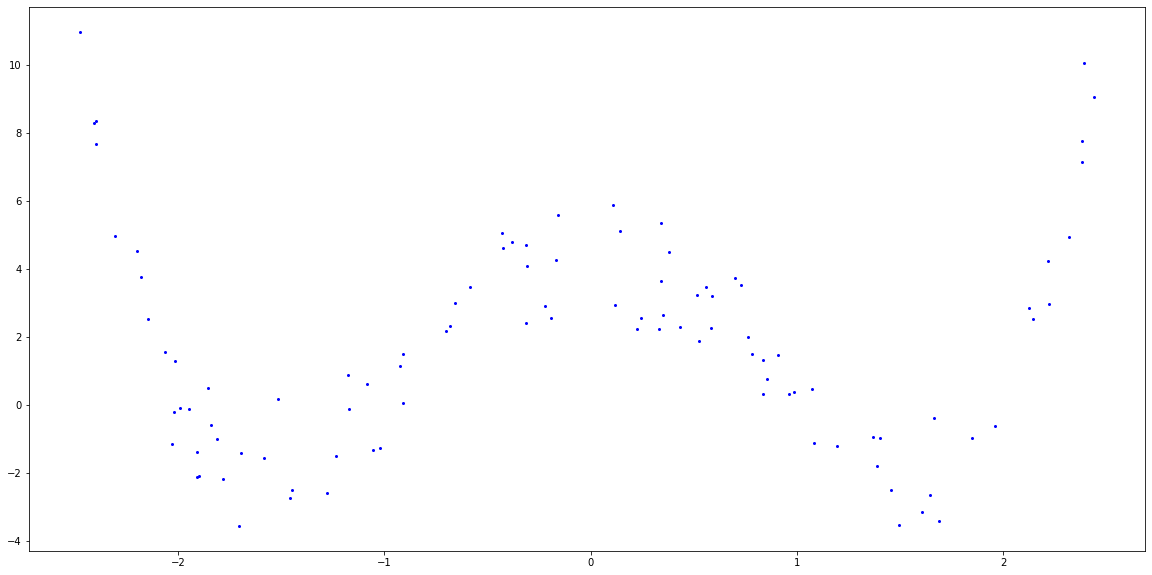

In [21]:
def makeTestTrainSample(N_train, N_test, sigma, seed):
    np.random.seed(seed) #Set the seed for deterministic answers
    X_train = np.random.uniform(-2.5,2.5,N_train) #Create X_train vector of N entries 
    epsilon_train = np.random.normal(loc=0.0, scale=sigma, size=N_train) #Create epsilon with sigma 0.1
    X2_train = np.square(X_train)
    Y_train = np.square(X2_train) - 5*X2_train + 4 + epsilon_train

    X_test = np.random.uniform(-2.5,2.5,N_test)
    epsilon_test = np.random.normal(loc=0.0, scale=sigma, size=N_test)
    X2_test = np.square(X_test)
    Y_test = np.square(X2_test) - 5*X2_test + 4 + epsilon_test
    return (X_train, Y_train, X_test, Y_test)

(X_train, Y_train, X_test, Y_test) = makeTestTrainSample(N_train = 100, N_test = 100, sigma = 1, seed = 0)
plt.figure(figsize=(20,10))
plt.plot(X_train, Y_train,'bo',markersize=2)

In [22]:
#fit polynomials of degree 1, 2, 3, 4, 5, 10 and 100 to the data.
#And lets measure the mean square error in train and test set
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

degree = range(1, 30)
mses_train = []
mses_test = []
for deg in degree:
    polynomial_features= PolynomialFeatures(degree=deg) #Use sklearn polynomialfeatures to generate polynomial features
    xp_train = polynomial_features.fit_transform(X_train.reshape(N_train,1))
    xp_test = polynomial_features.fit_transform(X_test.reshape(N_test,1))
    
    model = sm.OLS(Y_train, xp_train).fit() #Fit an OLS model
    
    ypred_train = model.predict(xp_train) #Make a prediction in the train data
    ypred_test = model.predict(xp_test) #Make a prediction on the test data
    mse_train = np.sum(np.square(ypred_train - Y_train)) / N_train #Mean square error in train data
    mses_train.append(mse_train)
    mse_test = np.sum(np.square(ypred_test - Y_test)) / N_test #Mean square error in test data
    mses_test.append(mse_test)
    

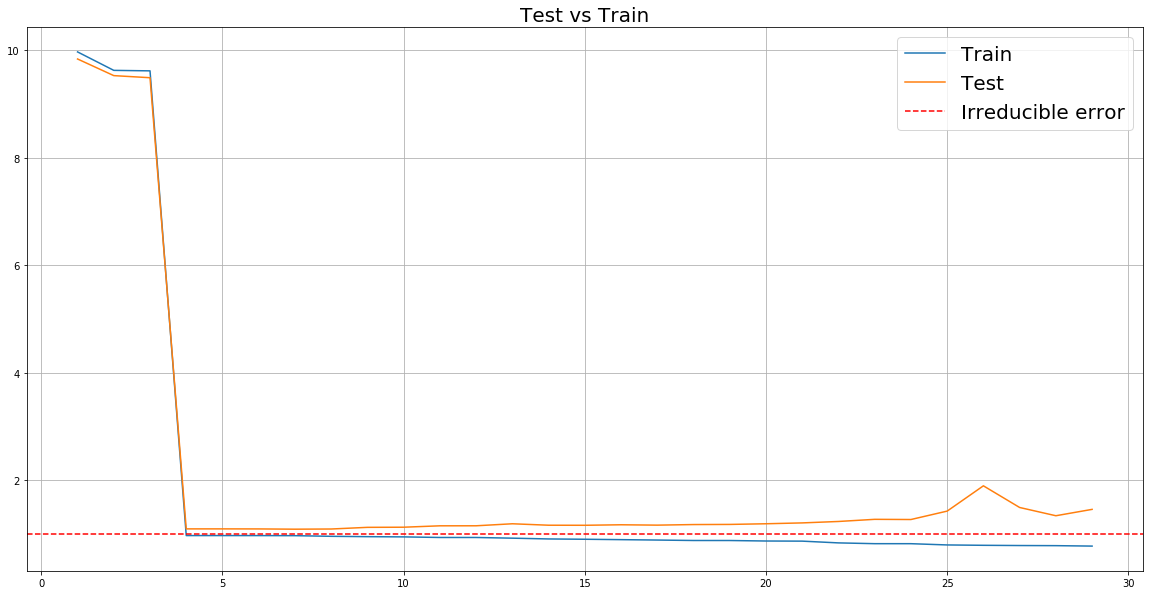

In [23]:
#Plot the Mean square error of test and train set
plt.figure(figsize=(20,10))
plt.title('Test vs Train', fontsize=20)
plt.plot(degree, mses_train, label='Train')
plt.plot(degree, mses_test, label='Test')
plt.axhline(y=1, color='r', linestyle='--',label='Irreducible error')
plt.grid()
plt.legend(fontsize=20)

We can see from the plot above as the model complexity goes up train error keeps on going down, but test error starts going up. Test error also stays above **irreducible** error.  

Now lets break the test MSE in bias, variance and irreducible term.

In [56]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

(X_train, Y_train, X_test, Y_test) = makeTestTrainSample(N_train = 1000, N_test = 100, sigma = 1, seed = 0)
NSample = 10
degree = range(1, 30)
N_train = 100
N_test = 100
mses_test = dict()
ypred_test = dict()
for i in range(0, NSample):
    X = X_train[i*100:(i+1)*100]
    Y = Y_train[i*100:(i+1)*100]  
    mses_test[i] = list()
    ypred_test[i] = dict()
    for deg in degree:
        polynomial_features= PolynomialFeatures(degree=deg) #Use sklearn polynomialfeatures to generate polynomial features
        xp_train = polynomial_features.fit_transform(X.reshape(N_train,1))
        xp_test = polynomial_features.fit_transform(X_test.reshape(N_test,1))
    
        model = sm.OLS(Y, xp_train).fit() #Fit an OLS model  
        ypred_test[i][deg] = model.predict(xp_test) #Make a prediction on the test data
             
        mse_test = np.sum(np.square(ypred_test[i][deg] - Y_test)) / N_test #Mean square error in test data
        mses_test[i].append(mse_test)

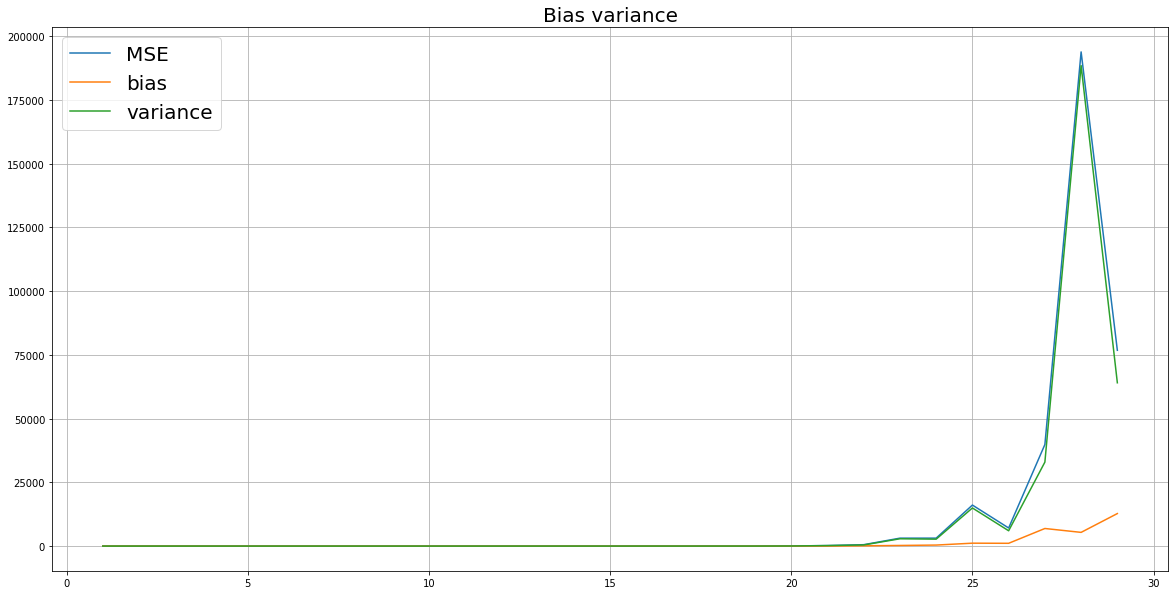

In [90]:
mean_mses = np.zeros(len(degree))
for i in range(0, NSample):
    mean_mses += mses_test[i]
    
mean_mses = mean_mses / (1.0 * NSample)


ypmean = dict()
biases = list()
variances = list()
X2_test = np.square(X_test)
Y_test_real = np.square(X2_test) - 5*X2_test + 4 
for deg in degree:
    ypmean[deg]=np.zeros(N_test)
    for i in range(0, NSample):
        ypmean[deg] += ypred_test[i][deg]

    ypmean[deg] /= (1.0 * NSample)
    
    bias = np.sum(np.square(ypmean[deg]-Y_test_real))/N_train
    biases.append(bias)
    var = 0
    for i in range(0, NSample):
        var += np.sum(np.square(ypred_test[i][deg] - ypmean[deg]))/N_train
    var = var/NSample
    variances.append(var)

plt.figure(figsize=(20,10))
plt.plot(degree, mean_mses,label = 'MSE')
plt.title('Bias variance', fontsize=20)
plt.plot(degree, biases, label='bias')
plt.plot(degree, variances, label='variance')
plt.grid()
plt.legend(fontsize=20)

We can note from the above plot as the model complexity increases bias goes up but variance goes up significantly. From the above example you can see that bias and variance is not always a trade off. Many times with overfitting both of them go up.